### Import librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore'
                        , category = ConvergenceWarning
                        , module = 'sklearn')

### Función creación de la matríz de confusión.

In [2]:
def matriz(y, pred, Modelo = ''):
    mc = confusion_matrix(y, pred)
    Total = sum(np.transpose(mc))
    mcr = np.transpose(np.round(np.transpose(mc) / Total * 100,2))
    
    MC = pd.DataFrame(mc, columns=['No', 'Si'])
    MC['index'] = ['No', 'Si']
    MC['No'] *= -1

    Grafico = MC.set_index('index').sort_values(['index']
                                                , ascending=False).plot(kind = 'barh'
                                                                        , stacked = True
                                                                        , width = 0.75
                                                                        , color=[['#c9c9c9','#e60000'],['#00c800','#c9c9c9']]
                                                                        , legend = False
                                                                        , figsize = (3,1.2))
    
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().grid(axis='x',alpha=0)
    plt.gca().grid(axis='y',alpha=0)
    plt.gca().set_xlabel('{:.2f} % - '.format(np.mean(y == pred) * 100) + Modelo
                         , fontsize = 12
                         , alpha = 0.6)
    plt.gca().set_ylabel('')
    
    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    
    plt.show()

### Función para ejecutar los modelos pasándolos un clasificador y devolver la matriz de confusión

In [3]:
def Clasificar(clf):
    clf.fit(XE, ye)

    pred = clf.predict(XT)

    matriz(yt, pred, Modelo = 'PassiveAggressiveClassifier')
    print(f'Accuracy sobre base test: {round(np.mean(yt == pred) * 100, 2)}%')  

### Importación de datos
* Datos de origen en la Url de <i><a href="https://www.kaggle.com/c/fake-news/data">Kaggel</a></i>

In [4]:
df = (pd.read_csv('train.csv')
      .sample(frac = 1, random_state = 0)
      .set_index('id')
      .fillna(' '))

df.head(3)

,title,author,text,label
id,,,,
20386,Bob Dylan’s Nobel Prize: A Podcast Discussion ...,Jon Pareles,Listen to this week’s podcast | Subscribe: iTu...,0
16794,Nuclear Weapons in South Korea under Discussio...,Author,"Country: South Korea In October 2016, the Pres...",1
5500,Solar Storm Alert,No Author,"October 27, 2016 Solar winds triggered a giant...",1


In [5]:
TfidfVec = TfidfVectorizer(stop_words = 'english'
                           , max_df = 0.7)

XE, XT, ye, yt = train_test_split(TfidfVec.fit_transform(df.text + ' ' + df.author + ' ' + df.title)
                                  , df.label
                                  , test_size = 0.75
                                  , random_state = 0)

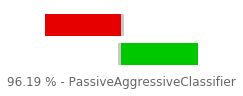

Accuracy sobre base test: 96.19%


In [6]:
clf = PassiveAggressiveClassifier(max_iter = 50)
Clasificar(clf)

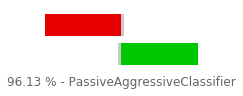

Accuracy sobre base test: 96.13%


In [7]:
clf = LogisticRegression(C = 1e5)
Clasificar(clf)